#**LABORATORIO 2 - MLP PYTORCH**

Nombre: Gonzales Suyo Franz Reinaldo

Dirección de GitHub:

##*LABORATORIO 2*

###Construir un MLP, con pytorch, considerando lo siguiente:

- El MLP, debe servir para realizar clasificaciones de al menos 5 clases o tipos de difentes ambitos.

- El MLP debe contener al menos 50 unidades  neuronales en una capa oculta.

- Se debe entrenar por almenos 1000 epochs y explicar que sucede en este proceso.

- Se debe implementar un mecanismo de checkpoints para el proceso de entrenamiento que permita respaldar los valores calculados para los parametros, cada 20 epochs.

- Aplicar las formas (frameworks) de exportación de modelos Torchscript y ONNX, a traves de ejemplos.

- Utilizar de manera obligatoria objetos dataset y dataloader en la implementacion.

- Se debe aplicar las tecnicas de normalizacion, optimizacion y buenas practicas para lograr el menor valor de costo y el mayor valor de precision.


Se debe subir todo a un repositorio el cual debes ser compartido, ademas de subir todos los cuadernillos o codigo fuente generados.

In [ ]:
# IMPORTAMOS LAS LIBRERIAS

import torch
import torchvision
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm  # Importar tqdm para la barra de progreso
from torch.cuda.amp import autocast, GradScaler  # Para mixed precision training

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**1: Lectura del Dataset**

Transformaciones: Redimensionamos los imagenes a 128x128 píxeles para convierten en tensores. La normalización se realiza para que los valores de píxeles estén en un rango adecuado para el entrenamiento del modelo.

In [ ]:
# Definir las transformaciones para las imágenes
from torchvision import datasets, transforms
import torch.utils.data

# Definir las transformaciones para el conjunto de datos
transform = transforms.Compose([
    transforms.Resize((50, 50)),  # Redimensionar las imágenes a 50x50 píxeles
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalización de las imágenes
])

# Cargar el conjunto de datos de entrenamiento y prueba con las transformaciones
train_data = datasets.ImageFolder(root='/content/drive/MyDrive/SIS420-IA2/Plantas Medicinales/plantas_train', transform=transform)
test_data = datasets.ImageFolder(root='/content/drive/MyDrive/SIS420-IA2/Plantas Medicinales/plantas_test', transform=transform)

# Mostrar la cantidad de imágenes de entrenamiento y prueba
print(f"Número de imágenes de entrenamiento: {len(train_data)}")
print(f"Número de imágenes de prueba: {len(test_data)}")

Número de imágenes de entrenamiento: 60000
Número de imágenes de prueba: 15000


In [ ]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import random

# Definir las transformaciones para el conjunto de datos
transform = transforms.Compose([
    transforms.Resize((50, 50)),  # Redimensionar las imágenes a 50x50 píxeles
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalización de las imágenes
])

# Función para limitar el número de archivos de cada subcarpeta
def limit_dataset_size(root_dir, max_per_class=6000):
    # Diccionario para almacenar rutas de las imágenes seleccionadas por clase
    limited_dataset = []

    # Iteramos por las subcarpetas en root_dir (cada subcarpeta es una clase)
    for class_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            # Obtenemos todas las imágenes en la subcarpeta
            all_images = os.listdir(class_dir)
            # Filtramos para obtener solo imágenes, excluyendo otros tipos de archivos
            all_images = [os.path.join(class_name, img) for img in all_images if img.endswith(('.png', '.jpg', '.jpeg'))]
            # Seleccionamos aleatoriamente 6000 imágenes
            selected_images = random.sample(all_images, min(len(all_images), max_per_class))
            limited_dataset.extend(selected_images)

    return limited_dataset



In [ ]:
# Definir la ruta del dataset
root_dir = '/content/drive/MyDrive/SIS420-IA2/Plantas Medicinales/plantas_train'

# Obtener una lista de las rutas de imágenes limitadas a 6000 por clase
limited_image_paths = limit_dataset_size(root_dir, max_per_class=6000)

# Clase personalizada para cargar solo las imágenes seleccionadas
class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, selected_files, transform=None):
        super(CustomImageFolder, self).__init__(root, transform=transform)
        # Filtrar el dataset para cargar solo las imágenes seleccionadas
        self.samples = [(os.path.join(root, img), self.class_to_idx[img.split('/')[0]]) for img in selected_files]
        self.targets = [s[1] for s in self.samples]  # Extraer las etiquetas

# Crear el dataset personalizado usando solo las imágenes seleccionadas
train_data = CustomImageFolder(root=root_dir, selected_files=limited_image_paths, transform=transform)

# Verificar el número de imágenes en el nuevo conjunto de entrenamiento
print(f"Número total de imágenes en el nuevo conjunto de entrenamiento: {len(train_data)}")

# Verificar el número de imágenes por clase
from collections import Counter
print("Distribución de imágenes por clase:", Counter(train_data.targets))

Número total de imágenes en el nuevo conjunto de entrenamiento: 30000
Distribución de imágenes por clase: Counter({0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000})


In [ ]:
# 1. Ver las etiquetas del dataset (clases):
# Ver las clases del dataset (etiquetas)
print(f"Clases en el conjunto de entrenamiento: {train_data.classes}")
print(f"Cantidad de clases: {len(train_data.classes)}")

Clases en el conjunto de entrenamiento: ['Acelga', 'Cebolla', 'Espinaca', 'Lechuga', 'Toronjil']
Cantidad de clases: 5


In [ ]:
import torch
from collections import Counter

# Verificar el número total de imágenes en el conjunto de entrenamiento
num_total_images = len(train_data)
print(f"Número total de imágenes en el conjunto de entrenamiento: {num_total_images}")

# Verificar el número de clases (etiquetas)
num_classes = len(train_data.classes)
print(f"Número de clases: {num_classes}")

# Obtener las etiquetas de todas las imágenes (train_data.targets tiene las etiquetas de cada imagen)
class_distribution = Counter(train_data.targets)

# Mostrar cuántas imágenes hay por clase
for class_idx, count in class_distribution.items():
    print(f"Clase '{train_data.classes[class_idx]}' tiene {count} imágenes")


Número total de imágenes en el conjunto de entrenamiento: 30000
Número de clases: 5
Clase 'Acelga' tiene 6000 imágenes
Clase 'Cebolla' tiene 6000 imágenes
Clase 'Espinaca' tiene 6000 imágenes
Clase 'Lechuga' tiene 6000 imágenes
Clase 'Toronjil' tiene 6000 imágenes


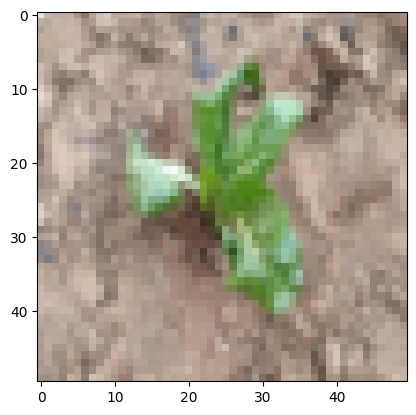

Etiquetas: Acelga


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Función para mostrar imágenes
def imshow(img):
    img = img / 2 + 0.5  # Desnormalizar la imagen
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Mostrar algunas imágenes del conjunto de entrenamiento
dataiter = iter(train_data)
images, labels = next(dataiter)

# Mostrar las imágenes
imshow(torchvision.utils.make_grid(images))

# Mostrar las etiquetas correspondientes
# Check if labels is an integer and convert it to a list if necessary
if isinstance(labels, int):
    labels = [labels]

print('Etiquetas:', ' '.join(f'{train_data.classes[labels[j]]}' for j in range(len(labels))))

In [ ]:
# Preparar los DataLoaders en formato de diccionario
dataloader = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=True)
}

# Mostrar la cantidad de imágenes de entrenamiento y prueba
print(f"Número de imágenes de entrenamiento: {len(train_data)}")
print(f"Número de imágenes de prueba: {len(test_data)}")

Número de imágenes de entrenamiento: 60000
Número de imágenes de prueba: 15000


In [ ]:
# Obtener un lote de imágenes y etiquetas del DataLoader de entrenamiento
images, labels = next(iter(dataloader['train']))

# Mostrar el tamaño del lote de imágenes y etiquetas
print(f"Tamaño del lote de imágenes: {images.shape}")  # Dimensiones del tensor de imágenes
print(f"Tamaño del lote de etiquetas: {labels.shape}")  # Dimensiones del tensor de etiquetas

# Ver la primera etiqueta en el lote y su correspondencia con la clase
print(f"Primera etiqueta en el lote: {labels[0].item()}")  # Mostrar el valor de la primera etiqueta
print(f"Clase correspondiente: {train_data.classes[labels[0]]}")  # Mostrar la clase asociada

Tamaño del lote de imágenes: torch.Size([64, 3, 50, 50])
Tamaño del lote de etiquetas: torch.Size([64])
Primera etiqueta en el lote: 4
Clase correspondiente: Toronjil


Aplicamos la utilización de los objetos de dataset y DataLoader para poder facilitar los dataset de grandes magnitudes dividiendo en lotes de batch_size

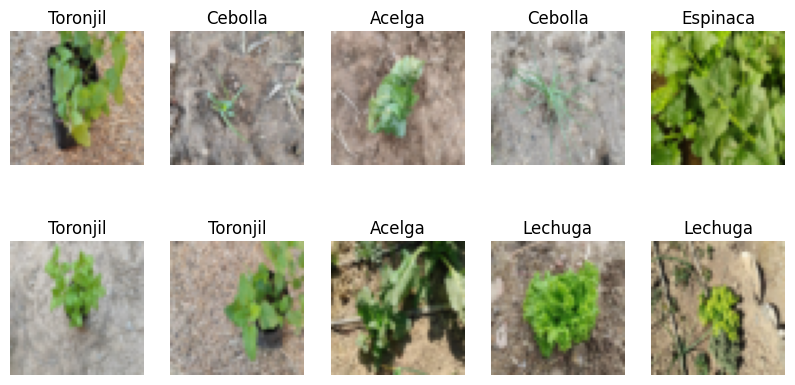

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Obtener las clases del dataset
classes = train_data.classes

# Convertir las imágenes y etiquetas a arrays numpy para facilitar el procesamiento
def imshow(img):
    img = img / 2 + 0.5     # Desnormalizar
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

# Mostrar 10 imágenes aleatorias
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    index = random.randint(0, len(train_data) - 1)
    img, label = train_data[index]
    plt.imshow(imshow(img))
    plt.title(classes[label])
    plt.axis('off')

plt.show()

#**2: Construcción del Modelo MLP**

Ahora realizaremos la arquitectura del MLP, asegurando que cumpla con las especificaciones: al menos 50 unidades neuronales en una capa oculta y una capa de salida con 5 unidades, una para cada clase de planta.

In [ ]:

import torch.nn as nn
import torch.nn.functional as F

# Definir un bloque secuencial de capas fully connected con activación y dropout
def fc_block(input_size, output_size, dropout_rate=0.5):
    return nn.Sequential(
        nn.Linear(input_size, output_size),  # Capa totalmente conectada (fully connected)
        nn.ReLU(),                           # Activación ReLU
        nn.Dropout(dropout_rate)             # Dropout para regularización
    )

class MLP(nn.Module):
    def __init__(self, input_size=50*50*3, n_classes=5):
        super(MLP, self).__init__()
        # Definir las capas fully connected utilizando bloques
        self.fc1 = fc_block(input_size, 50, dropout_rate=0.5)  # Capa de entrada con 7500 unidades y 50 neuronas
        self.fc2 = fc_block(50, 30, dropout_rate=0.5)         # Capa oculta con 30 unidades de neuronas
        self.fc3 = nn.Linear(30, n_classes)                    # Capa de salida con 5 clases (una por cada planta)

    def forward(self, x):
        x = x.view(-1, 50 * 50 * 3)  # Aplanar las imágenes
        x = self.fc1(x)              # Pasar a través del primer bloque fully connected
        x = self.fc2(x)              # Pasar a través del segundo bloque fully connected
        x = self.fc3(x)              # Pasar a través de la capa de salida
        return x


In [ ]:
# Configuración del dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


#**3: Configuración del Entrenamiento**

Entrenaremos el modelo durante 100 epochs, implementando un mecanismo de checkpoints para guardar el modelo cada 20 epochs. Además, aplicaremos técnicas de optimización y buenas prácticas.

In [ ]:
!pip install tqdm

In [ ]:
import torch
import numpy as np
from tqdm import tqdm

# Ruta donde se guardarán los checkpoints
checkpoint_dir = "/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-02/"

# Función para guardar un checkpoint en la ruta especificada
def save_checkpoint(epoch, model, optimizer, loss, filename='checkpoint.pth'):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    full_path = checkpoint_dir + filename  # Construir la ruta completa
    torch.save(checkpoint, full_path)
    print(f'Checkpoint guardado en: {full_path}')



# Función para cargar un checkpoint desde la ruta especificada
def load_checkpoint(filename, model, optimizer):
    full_path = checkpoint_dir + filename  # Construir la ruta completa
    checkpoint = torch.load(full_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f'Checkpoint cargado desde epoch {epoch} con pérdida {loss:.4f}')
    return epoch, loss

Entrenamiento desde cero y guardado de checkpoints:

In [ ]:
# Función para entrenar el modelo y guardar checkpoints automáticamente
def fit_train(model, dataloader, epochs=10, lr=1e-3, checkpoint_interval=5):
    model.to(device)  # Mover el modelo al dispositivo (CPU o GPU)

    # Optimizador Adam y función de pérdida CrossEntropy
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        # Inicializar listas para pérdidas y precisiones del entrenamiento
        model.train()
        train_loss, train_acc = [], []

        # Barras de progreso para los datos de entrenamiento
        bar = tqdm(dataloader['train'], desc=f"Epoch {epoch}/{epochs} - Training")

        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)  # Mover los datos al dispositivo

            # Reiniciar gradientes
            optimizer.zero_grad()

            # Forward pass (propagación hacia adelante)
            y_hat = model(X)

            # Cálculo de la pérdida
            loss = criterion(y_hat, y)

            # Backward pass (retropropagación) y actualización del optimizador
            loss.backward()
            optimizer.step()

            # Guardar el valor de la pérdida
            train_loss.append(loss.item())

            # Cálculo de precisión
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)

            # Actualización de la barra de progreso
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        # Validación del modelo después de cada época
        model.eval()  # Cambiar a modo de evaluación
        val_loss, val_acc = [], []

        with torch.no_grad():  # Desactivar el cálculo del gradiente
            bar = tqdm(dataloader['test'], desc=f"Epoch {epoch}/{epochs} - Validation")

            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)

                # Forward pass en modo evaluación
                y_hat = model(X)

                # Cálculo de la pérdida de validación
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())

                # Cálculo de la precisión de validación
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)

                # Actualización de la barra de progreso
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")

        # Mostrar métricas al final de la época
        print(f"Epoch {epoch}/{epochs} - Train loss: {np.mean(train_loss):.5f} - Validation loss: {np.mean(val_loss):.5f} - Train acc: {np.mean(train_acc):.5f} - Validation acc: {np.mean(val_acc):.5f}")

        # Guardar checkpoint cada cierto número de epochs
        if epoch % checkpoint_interval == 0:
            save_checkpoint(epoch, model, optimizer, np.mean(train_loss), filename=f'MLP_checkpoint_epoch_{epoch}.pth')


In [ ]:
# Crear instancia del modelo MLP y entrenar desde cero
model = MLP()
fit_train(model, dataloader, epochs=10, lr=1e-3, checkpoint_interval=2)

val_loss 0.45530 val_acc 0.82877: 100%|██████████| 235/235 [45:36<00:00, 11.64s/it]


Epoch 1/10 - Train loss: 0.90641 - Validation loss: 0.45530 - Train acc: 0.63337 - Validation acc: 0.82877


val_loss 0.34417 val_acc 0.88606: 100%|██████████| 235/235 [04:33<00:00,  1.16s/it]


Epoch 2/10 - Train loss: 0.61261 - Validation loss: 0.34417 - Train acc: 0.76320 - Validation acc: 0.88606
Checkpoint guardado en: /content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-02/MLP_checkpoint_epoch_2.pth


val_loss 0.26551 val_acc 0.91161: 100%|██████████| 235/235 [04:27<00:00,  1.14s/it]


Epoch 3/10 - Train loss: 0.52254 - Validation loss: 0.26551 - Train acc: 0.80561 - Validation acc: 0.91161


val_loss 0.24711 val_acc 0.92821: 100%|██████████| 235/235 [04:33<00:00,  1.16s/it]


Epoch 4/10 - Train loss: 0.47109 - Validation loss: 0.24711 - Train acc: 0.82630 - Validation acc: 0.92821
Checkpoint guardado en: /content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-02/MLP_checkpoint_epoch_4.pth


val_loss 0.21235 val_acc 0.93453: 100%|██████████| 235/235 [04:23<00:00,  1.12s/it]


Epoch 5/10 - Train loss: 0.42807 - Validation loss: 0.21235 - Train acc: 0.84637 - Validation acc: 0.93453


val_loss 0.19793 val_acc 0.94291: 100%|██████████| 235/235 [04:31<00:00,  1.16s/it]


Epoch 6/10 - Train loss: 0.40887 - Validation loss: 0.19793 - Train acc: 0.85116 - Validation acc: 0.94291
Checkpoint guardado en: /content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-02/MLP_checkpoint_epoch_6.pth


val_loss 0.18425 val_acc 0.94577: 100%|██████████| 235/235 [04:28<00:00,  1.14s/it]


Epoch 7/10 - Train loss: 0.37669 - Validation loss: 0.18425 - Train acc: 0.86580 - Validation acc: 0.94577


val_loss 0.17084 val_acc 0.95324: 100%|██████████| 235/235 [04:36<00:00,  1.18s/it]


Epoch 8/10 - Train loss: 0.37066 - Validation loss: 0.17084 - Train acc: 0.86854 - Validation acc: 0.95324
Checkpoint guardado en: /content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-02/MLP_checkpoint_epoch_8.pth


val_loss 0.16735 val_acc 0.94313: 100%|██████████| 235/235 [04:26<00:00,  1.13s/it]


Epoch 9/10 - Train loss: 0.35444 - Validation loss: 0.16735 - Train acc: 0.87446 - Validation acc: 0.94313


val_loss 0.16056 val_acc 0.95157: 100%|██████████| 235/235 [04:23<00:00,  1.12s/it]

Epoch 10/10 - Train loss: 0.34468 - Validation loss: 0.16056 - Train acc: 0.88074 - Validation acc: 0.95157
Checkpoint guardado en: /content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-02/MLP_checkpoint_epoch_10.pth


Cargar un modelo desde un checkpoint y continuar el entrenamiento:

In [ ]:
# Función para continuar el entrenamiento desde un checkpoint
def fit_train_continue(model, dataloader, checkpoint_filename, epochs=10, lr=1e-3, checkpoint_interval=5):
    model.to(device)  # Mover el modelo al dispositivo (CPU o GPU)

    # Optimizador Adam y función de pérdida CrossEntropy
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    # Cargar el checkpoint
    start_epoch, _ = load_checkpoint(checkpoint_filename, model, optimizer)

    for epoch in range(start_epoch + 1, epochs + 1):
        # Inicializar listas para pérdidas y precisiones del entrenamiento
        model.train()
        train_loss, train_acc = [], []

        # Barras de progreso para los datos de entrenamiento
        bar = tqdm(dataloader['train'], desc=f"Epoch {epoch}/{epochs} - Training")

        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)  # Mover los datos al dispositivo

            # Reiniciar gradientes
            optimizer.zero_grad()

            # Forward pass (propagación hacia adelante)
            y_hat = model(X)

            # Cálculo de la pérdida
            loss = criterion(y_hat, y)

            # Backward pass (retropropagación) y actualización del optimizador
            loss.backward()
            optimizer.step()

            # Guardar el valor de la pérdida
            train_loss.append(loss.item())

            # Cálculo de precisión
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)

            # Actualización de la barra de progreso
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        # Guardar checkpoint cada cierto número de epochs
        if epoch % checkpoint_interval == 0:
            save_checkpoint(epoch, model, optimizer, np.mean(train_loss), filename=f'MLP_checkpoint_epoch_{epoch}.pth')


In [ ]:
# Cargar el modelo desde el último checkpoint guardado y continuar el entrenamiento
model = MLP()
fit_train_continue(model, dataloader, checkpoint_filename='MLP_checkpoint_epoch_5.pth', epochs=15, lr=1e-3, checkpoint_interval=5)

##Evalucion del Modelo MLP

In [ ]:
def evaluate(model, dataloader):
    model.eval()  # Establecer el modelo en modo de evaluación
    model.to(device)  # Mover el modelo al dispositivo adecuado (CPU/GPU)

    bar = tqdm(dataloader['test'], desc="Evaluating")  # Barra de progreso para la evaluación
    accuracy = []  # Lista para almacenar las precisiones

    with torch.no_grad():  # Desactivar el cálculo de gradientes
        for batch in bar:
            X, y = batch  # Obtener las entradas (X) y etiquetas (y) del lote
            X, y = X.to(device), y.to(device)  # Mover los datos al dispositivo

            # Realizar una predicción con el modelo
            y_hat = model(X)

            # Calcular la precisión
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            accuracy.append(acc)

            # Actualizar la barra de progreso con la precisión promedio actual
            bar.set_description(f"acc {np.mean(accuracy):.5f}")

    # Imprimir la precisión final de la evaluación
    print(f"Evaluación completada - Precisión promedio: {np.mean(accuracy):.5f}")


In [ ]:
# Evaluar el modelo MLP
evaluate(model, dataloader)

acc 0.95157: 100%|██████████| 235/235 [04:35<00:00,  1.17s/it]

Evaluación completada - Precisión promedio: 0.95157


In [ ]:
print(model)

MLP(
  (fc1): Sequential(
    (0): Linear(in_features=7500, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=50, out_features=30, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc3): Linear(in_features=30, out_features=5, bias=True)
)


##Haciendo las pruebas de predicción los datos de prueba

###CARGAMOS LOS MODELOS ENTRENADOS.

Cargamos el modelo entrenado

In [ ]:
import torch

# Crear una instancia del modelo (asegúrate de que la arquitectura sea la misma)
model = MLP()  # Reemplaza MLP con la clase de tu modelo si es diferente

# Cargar los pesos del modelo guardado
model.load_state_dict(torch.load('/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-02/MLP_checkpoint_epoch_10.pth'))

# Mover el modelo al dispositivo adecuado (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


MLP(
  (fc1): Sequential(
    (0): Linear(in_features=7500, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=50, out_features=30, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc3): Linear(in_features=30, out_features=5, bias=True)
)

PRUEBAS CON UNA IMAGEN FOTOGRÁFICA

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Definir las transformaciones para las imágenes (debe coincidir con las del entrenamiento)
transform = transforms.Compose([
    transforms.Resize((50, 50)),  # Reducir el tamaño de la imagen a 50x50 píxeles
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar los tensores
])


In [ ]:
# Función para hacer predicciones
def predict_image(image_path):
    # Cargar la imagen
    image = Image.open(image_path)

    # Aplicar las transformaciones
    image_tensor = transform(image).unsqueeze(0)  # Añadir una dimensión para el batch

    # Realizar la predicción
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()



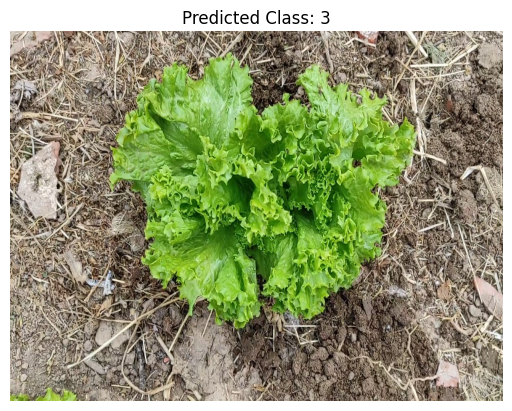

In [ ]:
# Ruta de la imagen a probar
# image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/acelga_08989.jpg'  # Cambia esto a la ruta de tu imagen
# image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/cebolla_00386.jpg'
# image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/espinaca_00408.jpg'
image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/lechuga_00066.jpg'
# image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/toronjil_00022.jpg'
# image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/lechuga.jpeg'

# Obtener la clase predicha
predicted_class = predict_image(image_path)

# Mostrar la imagen y el resultado
image = Image.open(image_path)
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()

#**4: Exportación del Modelo (TorchScript y ONNX)**

Una vez entrenado el modelo, lo exportamos a los formatos TorchScript y ONNX.

In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 66.8 MB/s eta 0:00:00


In [ ]:
import torch

# Exportar el modelo a TorchScript y ONNX
# TorchScript: torch.jit.trace permite exportar el modelo, manteniendo su
# estructura y lógica, lo cual es útil para implementaciones en producción.

scripted_model = torch.jit.script(model)
scripted_model.save('model_scripted.pt')

# ONNX: Proporciona interoperabilidad, permitiendo que el modelo se utilice en diferentes frameworks.
# Install onnx if you haven't already
!pip install onnx
import onnx # Import the onnx module

dummy_input = torch.randn(1, 3, 50, 50, device=device)
torch.onnx.export(model, dummy_input, 'model.onnx', verbose=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 48.9 MB/s eta 0:00:00


In [ ]:

# Exportar a TorchScript
example_input = torch.randn(1, 3, 50, 50)  # Ejemplo de entrada
traced_script_module = torch.jit.trace(model, example_input)
traced_script_module.save("mlp_model_script.pt")

# Exportar a ONNX
torch.onnx.export(model, example_input, "mlp_model.onnx", export_params=True, opset_version=10,
                  do_constant_folding=True, input_names=['input'], output_names=['output'])

#============================================================================================
#=============================================================================================

#**1. APLICANDO BUENAS PRÁCTICAS - RECETA DE ENTRENAMIENTO**

In [ ]:
# CARGAR LOS DATASET

# CARGAMOS LOS DATASET DE ENTRENAMIENTO Y PRUEBA

import torch
from torch.utils.data import Dataset, DataLoader

class PlantasDataset(Dataset):
    def __init__(self, archivo_dataset):
        self.imagenes, self.etiquetas = torch.load(archivo_dataset)

    def __len__(self):
        return len(self.etiquetas)

    def __getitem__(self, idx):
        return self.imagenes[idx], self.etiquetas[idx]

# Cargar datasets
trainset = PlantasDataset('/content/drive/MyDrive/SIS420-IA2/Dataset/plants_train.pt')
testset = PlantasDataset('/content/drive/MyDrive/SIS420-IA2/Dataset/plants_test.pt')


print("Número de ejemplos en el conjunto de entrenamiento:", len(trainset))
print("Número de ejemplos en el conjunto de prueba:", len(testset))


<ipython-input-2-cb30a317a764>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.imagenes, self.etiquetas = torch.load(archivo_dataset)


Número de ejemplos en el conjunto de entrenamiento: 60000
Número de ejemplos en el conjunto de prueba: 15000


In [ ]:
# convertimos imágenes a arrays de numpy

import numpy as np

train_images = np.array([np.array(img) for img, label in trainset])
test_images = np.array([np.array(img) for img, label in testset])

train_labels = np.array([label for img, label in testset])
test_labels = np.array([label for img, label in testset])

In [ ]:
# ver número de imágenes, resolución y número de canales

train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((60000, 3, 50, 50), (15000, 3, 50, 50), (15000,), (15000,))

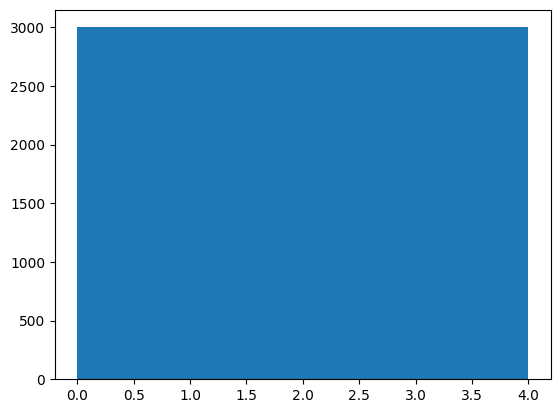

In [ ]:
# distribución de clases

# Nombramos los nombres de las clases que tendran nuestro dataset, en tipo de labels para las plantas
classes = ('Acelga', 'Cebolla', 'Espinaca', 'Lechuga', 'Toronjil')

plt.hist(train_labels[:30000], bins=len(classes))
plt.show()

##Validando nuestra red neuronal

In [ ]:
import torch

def build_model(D_in=50*50*3, H=100, D_out=5):
    # Sequential crea una secuencia de capas que se aplicarán una tras otra
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),

        # Segunda capa densa, toma la salida de la primera capa (de tamaño H)
        # y produce una salida también de tamaño H
        torch.nn.Linear(H, H),  # Capa totalmente conectada
        torch.nn.ReLU(),  # Otra capa de activación ReLU

        torch.nn.Linear(H, D_out)  # Capa de salida
    )
    # ).cuda()


In [ ]:
# Creamos el modelo llamando a la función previamente definida
model = build_model()
test_input = torch.randn((64, 50*50*3))  # .cuda()
# Pasamos la entrada de prueba a través del modelo para obtener la salida
test_output = model(test_input)
# Verificamos la forma de la salida
test_output.shape


torch.Size([64, 5])

In [ ]:
X_train, X_val, X_subset = train_images[:40000], train_images[40000:50000], train_images[50000:]
y_train, y_val, y_subset = train_labels[:40000], train_labels[40000:50000], train_labels[50000:]


X_train.shape, X_val.shape, test_images.shape, X_subset.shape

((40000, 3, 50, 50),
 (10000, 3, 50, 50),
 (15000, 3, 50, 50),
 (10000, 3, 50, 50))

In [ ]:

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        assert len(X) > 0, "El conjunto de datos X está vacío"
        assert len(Y) > 0, "El conjunto de datos Y está vacío"
        # Convertir X a tensores de PyTorch, normalizar y redimensionar
        self.X = torch.from_numpy(X / 255.).float().view(-1, 50*50*3)
        # Convertir Y a tensores de PyTorch
        self.Y = torch.from_numpy(Y).long()

    def __len__(self):
        # Retornar el tamaño del dataset
        return len(self.X)

    def __getitem__(self, ix):
        # Obtener un elemento del dataset
        return self.X[ix], self.Y[ix]

In [ ]:
import torch

epochs = 1000  # Número total de épocas para el entrenamiento
criterion = torch.nn.CrossEntropyLoss()  # Función de pérdida para clasificación
model = build_model()  # Construir el modelo MLP
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Optimizador Adam con tasa de aprendizaje

# Ruta del directorio donde se guardará el checkpoint
checkpoint_dir = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-02/Modelo_guardados/'

for e in range(1, epochs+1):  # Iterar sobre cada época
    for x_b, y_b in dataloader:  # Iterar sobre los batches del DataLoader
        y_pred = model(x_b)  # Realizar la predicción
        loss = criterion(y_pred, y_b)  # Calcular la pérdida
        optimizer.zero_grad()  # Limpiar los gradientes anteriores
        loss.backward()  # Retropropagación del error
        optimizer.step()  # Actualizar los pesos del modelo

        # Imprimir el progreso: época actual, pérdida y predicciones
        print(f"Epoch {e}/{epochs} loss {loss.item():.5f} y {y_b.item()} y_pred {torch.argmax(y_pred, axis=1).item()}")

# Guardar el modelo una vez que termine el entrenamiento
torch.save({
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item(),
}, f'{checkpoint_dir}mlp_model_checkpoint.pth')

print(f"Modelo guardado exitosamente en '{checkpoint_dir}mlp_model_checkpoint.pth'")


Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 737/1000 loss 0.00001 y 2 y_pred 2
Epoch 737/1000 loss 0.00001 y 1 y_pred 1
Epoch 738/1000 loss 0.00000 y 2 y_pred 2
Epoch 738/1000 loss 0.00001 y 0 y_pred 0
Epoch 738/1000 loss 0.00000 y 0 y_pred 0
Epoch 738/1000 loss 0.00000 y 0 y_pred 0
Epoch 738/1000 loss 0.00001 y 2 y_pred 2
Epoch 738/1000 loss 0.00000 y 4 y_pred 4
Epoch 738/1000 loss 0.00001 y 1 y_pred 1
Epoch 738/1000 loss 0.00002 y 4 y_pred 4
Epoch 738/1000 loss 0.00001 y 0 y_pred 0
Epoch 738/1000 loss 0.00001 y 4 y_pred 4
Epoch 738/1000 loss 0.00000 y 4 y_pred 4
Epoch 738/1000 loss 0.00001 y 0 y_pred 0
Epoch 738/1000 loss 0.00002 y 4 y_pred 4
Epoch 738/1000 loss 0.00001 y 4 y_pred 4
Epoch 738/1000 loss 0.00001 y 0 y_pred 0
Epoch 738/1000 loss 0.00002 y 3 y_pred 3
Epoch 738/1000 loss 0.00001 y 3 y_pred 3
Epoch 738/1000 loss 0.00001 y 2 y_pred 2
Epoch 738/1000 loss 0.00001 y 1 y_pred 1
Epoch 739/1000 loss 0.00000 y 2 y_pred 2
Epoch 739/1000 loss 0.00001 y 0 y_pre

#Entrenando con un sub-conjunto de datos

Entrenar una red neuronal en un dataset completo puede ser computacionalmente costoso si el dataset es muy grande. Esto implica que si queremos hacer pruebas para probar diferentes combinaciones de hyperparámetros vamos a tener que esperar mucho tiempo, o alquilar grandes clusters de GPUs (lo cual es muy caro). Una solución es iterar utilizando un sub-conjunto representativo de nuestro dataset, confiando en que las conclusiones a las que lleguemos en este pequeño conjunto luego se transfieran a todo el dataset.

In [ ]:
# Definimos el dataset con un subconjunto de datos para entrenamiento y validación
dataset = {
    'train': Dataset(X_subset, y_subset),  # Dataset para entrenamiento usando el subconjunto de datos
    'val': Dataset(X_val, y_val),          # Dataset para validación usando el conjunto de validación
}

# Creamos los DataLoaders para manejar el entrenamiento y la validación
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),  # DataLoader para entrenamiento
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)   # DataLoader para validación
}

# Mostramos el tamaño del dataset de entrenamiento y validación
print(f'Training dataset size: {len(dataset["train"])}')
print(f'Validation dataset size: {len(dataset["val"])}')

Training dataset size: 10000
Validation dataset size: 10000


In [ ]:
from sklearn.metrics import accuracy_score

def softmax(x):
    """
    Calcula la función softmax para la entrada x.

    """
    return torch.exp(x) / torch.exp(x).sum(axis=-1, keepdims=True)

def fit(model, dataloader, optimizer, scheduler=None, epochs=1000, log_each=1, weight_decay=0, early_stopping=0, verbose=1):
    """
    Entrena el modelo con el DataLoader proporcionado.
    Args:
        model (torch.nn.Module): El modelo a entrenar.
        dataloader (dict): Diccionario con DataLoaders para entrenamiento y validación.
        optimizer (torch.optim.Optimizer): Optimizador para actualizar los parámetros del modelo.
        scheduler (torch.optim.lr_scheduler, optional): Scheduler para ajustar la tasa de aprendizaje.
        epochs (int): Número de épocas para entrenar.
        log_each (int): Frecuencia para registrar el progreso del entrenamiento.
        weight_decay (float, optional): Decaimiento del peso para el optimizador.
        early_stopping (int, optional): Número de épocas sin mejora antes de detener el entrenamiento.
        verbose (int): Nivel de verbosidad (0 = nada, 1 = básico, 2 = detallado).
    Returns:
        dict: Resultados del entrenamiento (épocas, pérdida, precisión, etc.).
    """
    criterion = torch.nn.CrossEntropyLoss()  # Función de pérdida para clasificación
    l, acc, lr = [], [], []  # Listas para guardar pérdidas, precisión y tasa de aprendizaje
    val_l, val_acc = [], []  # Listas para pérdidas y precisión de validación
    best_acc, step = 0, 0  # Mejor precisión y contador de pasos para early stopping

    for e in range(1, epochs + 1):
        _l, _acc = [], []  # Listas para pérdidas y precisión en cada época
        for param_group in optimizer.param_groups:
            lr.append(param_group['lr'])  # Guardar tasa de aprendizaje actual

        model.train()  # Configura el modelo en modo entrenamiento

        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)  # Realizar predicciones
            loss = criterion(y_pred, y_b)  # Calcular pérdida
            _l.append(loss.item())  # Guardar pérdida
            optimizer.zero_grad()  # Limpiar gradientes
            loss.backward()  # Calcular gradientes
            optimizer.step()  # Actualizar parámetros

            y_probas = torch.argmax(softmax(y_pred), axis=1)  # Obtener predicciones de clase
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))  # Calcular precisión

        l.append(np.mean(_l))  # Promediar pérdida de entrenamiento
        acc.append(np.mean(_acc))  # Promediar precisión de entrenamiento

        model.eval()  # Configura el modelo en modo evaluación
        _l, _acc = [], []  # Listas para pérdidas y precisión en validación

        with torch.no_grad():  # Desactiva el cálculo de gradientes
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)  # Realizar predicciones
                loss = criterion(y_pred, y_b)  # Calcular pérdida
                _l.append(loss.item())  # Guardar pérdida
                y_probas = torch.argmax(softmax(y_pred), axis=1)  # Obtener predicciones de clase
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))  # Calcular precisión

        val_l.append(np.mean(_l))  # Promediar pérdida de validación
        val_acc.append(np.mean(_acc))  # Promediar precisión de validación

        # Guardar el mejor modelo basado en precisión de validación
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-02/Modelo_guardados/Chechpit_Sub_Conjunto_Datos.pt')  # Guardar el estado del modelo
            step = 0
            if verbose == 2:
                print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")

        step += 1  # Incrementar contador de pasos
        if scheduler:
            scheduler.step()  # Actualizar tasa de aprendizaje si se usa un scheduler

        # Early stopping si no hay mejora en el número de épocas especificado
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break

        # Registrar el progreso del entrenamiento
        if not e % log_each and verbose:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f} lr {lr[-1]:.5f}")

    # Cargar el mejor modelo guardado
    model.load_state_dict(torch.load('/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-02/Modelo_guardados/Chechpit_Sub_Conjunto_Datos.pt'))

    return {'epoch': list(range(1, len(l) + 1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc, 'lr': lr}


In [1]:
lrs = [0.003, 0.0002, 0.0001]
hists = []
for lr in lrs:
    print(f"Probando lr {lr}")
    model = build_model()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    hist = fit(model, dataloader, optimizer, epochs=100, verbose=0)
    hists.append(hist)

# tarda 5 minutos

#CONCLUSIÓN Y RESULTADOS

- **HiperParámetros**: Los hiperparámetros que se utilizaron fueron el valor de alpha coeficiente de aprendizaje de 0.001.

Para el modelo del MLP utilizamos 128*128*3 de entrada, un 50 capas ocultas y la última capa de salida que es de 5 clases diferentes.


Sobre los resultamos aún no se especificó los resultados correctos ya que se hacen muchas pruebas con diferentes tipos de hiperparámetros por lo que tendremos que entrenar muchas veces para sacar el mejor resultado.

####Tecnicas y Prácticas

- Regularización: Se añadió Dropout en el modelo para reducir el sobreajuste al apagar aleatoriamente un porcentaje de neuronas durante el entrenamiento.

- Optimización: Para la optimización del modelo aplicamos un optimizador que es el Adan que adapta las tasas de aprendizaje y estabiliza el entrenamiento. Existen otros que podriamos utilizar como Learning Rate Scheduling o Gradient Clipping, pero la más famosa que se utiliza es el Adan por lo cual percatamos a utilizar para la optimización del entrenamiento.

- Buenas Prácticas:

  . Utilizamos DataLoader para manejar el batching y aleatorización de los datos de entrenamiento y prueba
  
  . Checkpoints: Guardamos el estado del modelo y el optimizador cada 20 epochs para recuperar el progreso en caso de interrupciones.

  . Exportación del Modelo: Exportamos el modelo en dos
  formatos: TorchScript para su uso en producción y ONNX para interoperabilidad con otras plataformas.


####Entrenamiento y Evaluación

- Entrenamiento: El modelo se entrena durante 1000 epochs, donde en cada epoch se realiza el forward pass, cálculo de pérdida, retropropagación y actualización de pesos. La pérdida se imprime al final de cada epoch.

- Evaluación: Después del entrenamiento de cada epoch, se evalúa el modelo en el conjunto de prueba para calcular la precisión y verificar el rendimiento.